1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


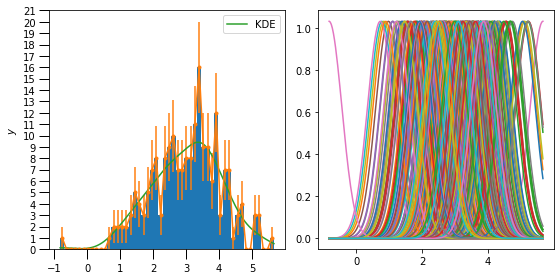

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy import stats
from scipy import integrate as inte
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter


N=200
mean=3
sigma=1
x=np.random.normal(mean, sigma, N)



fig, (ax1,ax2) =plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

#ax1.hist(x, bins=50)
y, binEdges, _=ax1.hist(x, bins=50)
ax1.set_ylabel('$y$')
ax1.xaxis.set_major_locator(MultipleLocator(1.0))
ax1.yaxis.set_major_locator(MultipleLocator(1.0))
ax1.tick_params(which='major', width=1.0)
ax1.tick_params(which='major', length=10)

bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
ax1.errorbar(bincenters, y, yerr=np.sqrt(y), marker = '.')


fig.tight_layout()

dstd=1.06*x.std()*x.size**(-1/5)

xs=np.linspace(x.min(), x.max(),200)


lgauss=[]

for i in x:
    gaus=stats.norm.pdf(xs,i,dstd)
    ax2.plot(xs, gaus)
    lgauss.append(gaus)

gauss_sum = np.sum(lgauss, axis=0)
integral0 = inte.trapz(y,bincenters )
integral1 = inte.trapz(gauss_sum,xs)

normalization = integral0/integral1
gauss_sum = gauss_sum * normalization
ax1.plot(xs,gauss_sum)
ax1.legend(['KDE'])




plt.show()
  



2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

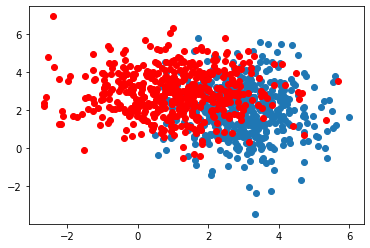

In [59]:
import pandas as pd

N=500
mean1 = [3, 2]
mean2=[1,3]
sigma1=[[1, 0], [0, 2]]
sigma2 = [[2, 0], [0, 1.5]]
A=np.random.multivariate_normal(mean1, sigma1, N)
A_x=[] 
A_y=[]
B_x=[]
B_y=[]
for i in A:
    A_x.append(i[0])
    A_y.append(i[1])
    
B=np.random.multivariate_normal(mean2, sigma2, N)

for i in B:
    B_x.append(i[0])
    B_y.append(i[1])

fig, ax=plt.subplots()

scatter=ax.scatter(x=A_x, y=A_y)
scatter=ax.scatter(x=B_x, y=B_y, c='red')

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy  -P /mnt/c/Users/chiara/LaboratoryOfComputationalPhysics_Y3/data

LinregressResult(slope=0.0032597701220305835, intercept=-0.15432816763069473, rvalue=0.043403510522559086, pvalue=8.717037183576464e-06, stderr=0.0007327014008445789) 

x:  [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
y:  [-1.77905556 -1.39652661 -0.98993016 -0.54962884 -0.17135776  0.13225169
  0.54241157  0.94979452  1.37835238  1.76490625]
erry:  [0.10901221 0.10854102 0.11269996 0.10826035 0.10727001 0.10520184
 0.11038606 0.10842129 0.10973401 0.10173621]


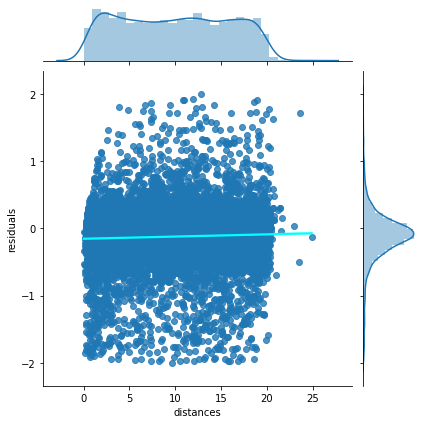

In [87]:
from scipy import stats
import seaborn as sns
a=np.load('/mnt/c/Users/chiara/LaboratoryOfComputationalPhysics_Y3/data/residuals_261.npy', allow_pickle=True).item()
df=pd.DataFrame(a)
df=df[abs(df['residuals'])<2 ]
df

x_1=df.distances
y_1=df.residuals

print(sp.stats.linregress(x_1,y_1), "\n")

plot=sns.jointplot(x_1,y_1, kind="reg",joint_kws={'line_kws':{'color':'cyan'}})



a,binEdges, _=stats.binned_statistic(x_1,x_1,'count', 10, range=(0,20))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
x=np.array(bincenters)
y, b_ed1, nbin1=stats.binned_statistic(y_1,y_1,'mean', 10)
erry, b_ed2, nbin2=stats.binned_statistic(y_1,y_1,'std', 10)


print("x: ", x)
print("y: ", y)
print("erry: ", erry)




